# Transfer Learning et Fine-Tuning avec BERT : Classification binaire de Sentiments

## Objectifs de ce notebook

Dans ce notebook, nous allons tester le **Transfer Learning** et le **Fine-Tuning** dans le domaine du NLP avec l'architecture **BERT**.

Les techniques qui seront appliquées:

- **Transfer Learning** - Utiliser un modèle pré-entraîné sur un language et l'adapter pour de la classification de sentiment et le vocabulaire particulier du jeux vidéos
- **Fine-Tuning** - Ré-entrainer toutes les couches BERT à notre tâche spécifique
- **Layer Freezing** : Geler certaines couches pour le transfer learning
- **Learning Rate Scheduling** : Stratégies d'optimisation pour le fine-tuning pendant l'entrainement

## Obtenir une première évaluation rapide (baseline)


- Utilisation du fichier nettoyé **Steam review anglais:** 'reviews_en_processed.csv' pour la classification de sentiments (positif/négatif).
- Technique transfert et finetuning sur un subset de reviews réduit (~20 000)

## Note sur les librairies utilisées

Ce notebook utilise backend **tensorflow** avec api **Keras 3 / KerasNLP**
Utilisation des preprocessing / tokenizer et des preset de modèles disponible dans kerasNLP
 - bert_tiny_en
 - bert_small_en
 etc.

## Imports et Configuration

### Import des libraires

In [1]:
# Bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

import warnings
warnings.filterwarnings('ignore')

# TensorFlow et Keras
import tensorflow as tf
import keras
from keras import layers, models

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

# KerasNLP pour BERT
import keras_nlp

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

2025-12-09 15:58:46.894953: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-09 15:58:46.963215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765292326.995069   21629 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765292327.005504   21629 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765292327.056637   21629 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Configuration GPU

In [2]:
# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("⚠️  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")

GPU(s) détecté(s): 1 - Croissance mémoire activée


### Configuration PLOTS et SEED

In [3]:
# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)

### Vérification version moteur deep learning

In [4]:
print(f"\nTensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"KerasNLP version: {keras_nlp.__version__}")


TensorFlow version: 2.19.1
Keras version: 3.11.3
KerasNLP version: 0.23.0


## Méthodes utiles

In [5]:
def column_summary(df: pd.DataFrame):
    summary = []
    for col in df.columns:
        col_type = df[col].dtype
        non_null = df[col].notna().sum()
        null_count = df[col].isna().sum()
        
        # Gérer le cas où la colonne contient des listes (unhashable)
        try:
            unique_count = df[col].nunique()
        except TypeError:
            # Si erreur (listes), convertir en string temporairement
            unique_count = df[col].astype(str).nunique()
            print(f"⚠️ Colonne '{col}' contient des types non-hashable (probablement des listes)")

        summary.append({
            'Column': col,
            'Type': str(col_type),
            'Non-Null Count': non_null,
            'Null Count': null_count,
            'Unique Values': unique_count,
        })

    # Afficher le résumé des colonnes
    print("=" * 80)
    print("Résumé détaillé des colonnes:")
    print("=" * 80)
    column_summary_df = pd.DataFrame(summary)
    print(column_summary_df.to_string(index=False))
    print("\n")

## Chargement et vérification des données des reviews anglaises (cleaned)

Executer au préalable le script de création du fichier des reviews anglaises suivant:

`python -m src.scripts.dataset.create_reviews_dataset_en_fr_for_fine_tuning`

.cache/kagglehub/datasets/kieranpoc/steam-reviews/versions/2/reviews_en_processed.csv`

### Récupération kaggle hub local cache path

In [6]:
path = kagglehub.dataset_download("kieranpoc/steam-reviews")

### Chargement dataset Anglais

In [7]:
df_reviews_en = pd.read_csv(
    f"{path}/reviews_en_processed.csv",
    
    low_memory=True  # Optimize memory usage
)

### Vérification données chargé

In [8]:
df_reviews_en.head()

,voted_up,review,weighted_vote_score
0,0,RIP Evolve 2015-2015. I pre-purchased this gam...,0.762631
1,0,This isn't a bad game. Theoretically Sanctum d...,0.632689
2,0,Bought this to check it out since the sequel j...,0.684002
3,1,"The game is GREAT, I really enjoyed the story ...",0.689321
4,0,"With over 1000 hours in The Binding of Isaac, ...",0.625691


In [9]:
column_summary(df_reviews_en)

Résumé détaillé des colonnes:
             Column    Type  Non-Null Count  Null Count  Unique Values
           voted_up   int64          229102           0              2
             review  object          229102           0         229102
weighted_vote_score float64          229102           0         215596




### Vérification équilibre des classes déjà en place

In [10]:
df_reviews_en["voted_up"].value_counts()

voted_up
0    114551
1    114551
Name: count, dtype: int64

### Création subset pour premiers Tests rapides, évaluation baseline

In [11]:
SUBSET_SIZE = 20000  # Utiliser 20000 reviews pour tests rapides

df_reviews_en_sample = df_reviews_en.sample(n=SUBSET_SIZE, random_state=42)

### Création Train / Val / Test

- **Train (80%)** : X_train_text + y_train  → entraîner
- **Val (10%)**    : X_val_text + y_val      → surveiller l'entraînement
- **Test (10%)**   : X_test_text + y_test    → évaluation finale

In [12]:
# Premier split : 80% train, 20% temp (val + test)
X_train_text, X_temp, y_train, y_temp = train_test_split(
    df_reviews_en_sample['review'],
    df_reviews_en_sample['voted_up'],
    test_size=0.2,  # 20% pour val+test
    stratify=df_reviews_en_sample['voted_up'],
    random_state=42
)

# Deuxième split : 50% val, 50% test (du temp qui fait 20%)
# 50% de 20% = 10% val, 50% de 20% = 10% test
X_val_text, X_test_text, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

X_train_text:pd.Series
y_train:pd.Series

X_val_text:pd.Series
y_val:pd.Series

X_test_text:pd.Series
y_test:pd.Series

X_train_text = X_train_text.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_val_text = X_val_text.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test_text = X_test_text.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Vérification train / val / test

In [13]:
# Vérifier les proportions
print(f"Train: {len(X_train_text)} ({len(X_train_text)/len(df_reviews_en_sample)*100:.1f}%)")
print(f"Val:   {len(X_val_text)} ({len(X_val_text)/len(df_reviews_en_sample)*100:.1f}%)")
print(f"Test:  {len(X_test_text)} ({len(X_test_text)/len(df_reviews_en_sample)*100:.1f}%)")

print("\nDistribution train:", y_train.value_counts(normalize=True))
print("\nDistribution val:", y_val.value_counts(normalize=True))
print("\nDistribution test:", y_test.value_counts(normalize=True))

# Statistiques de longueur de texte
train_lengths = [len(text.split()) for text in X_train_text]
print(f"\nLongueur moyenne des reviews train: {np.mean(train_lengths):.0f} mots")

val_lengths = [len(text.split()) for text in X_val_text]
print(f"\nLongueur moyenne des reviews val: {np.mean(val_lengths):.0f} mots")

test_lengths = [len(text.split()) for text in X_test_text]
print(f"\nLongueur moyenne des reviews test: {np.mean(test_lengths):.0f} mots")

Train: 16000 (80.0%)
Val:   2000 (10.0%)
Test:  2000 (10.0%)

Distribution train: voted_up
1    0.50125
0    0.49875
Name: proportion, dtype: float64

Distribution val: voted_up
1    0.5015
0    0.4985
Name: proportion, dtype: float64

Distribution test: voted_up
1    0.501
0    0.499
Name: proportion, dtype: float64

Longueur moyenne des reviews train: 116 mots

Longueur moyenne des reviews val: 123 mots

Longueur moyenne des reviews test: 117 mots


Longueur moyenne des reviews proche de 128 (sequence length)

### Graphiques vérification longueur et distribution

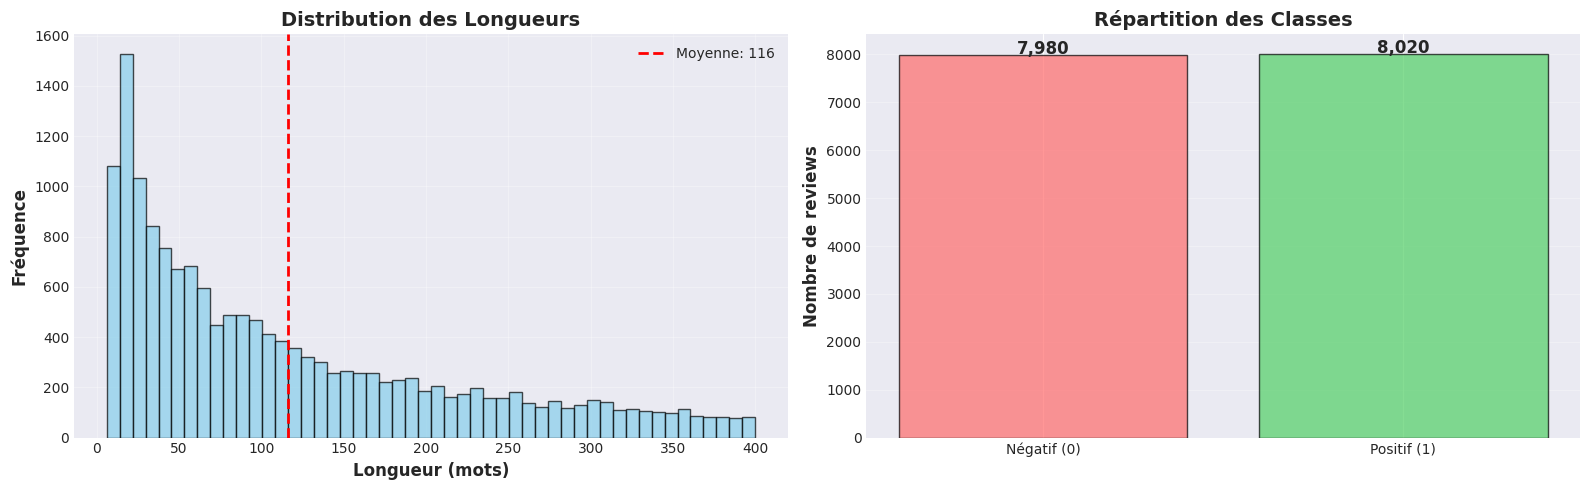

In [14]:
# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1 : plt.Axes
# Distribution des longueurs
ax1.hist(train_lengths, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(np.mean(train_lengths), color='red', linestyle='--', linewidth=2, 
            label=f'Moyenne: {np.mean(train_lengths):.0f}')
ax1.set_xlabel('Longueur (mots)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des Longueurs', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Distribution des classes
labels = ['Négatif (0)', 'Positif (1)']
counts = [np.sum(y_train == 0), np.sum(y_train == 1)]
colors = ['#ff6b6b', '#51cf66']

ax2 : plt.Axes
ax2.bar(labels, counts, color=colors, edgecolor='black', alpha=0.7)
ax2.set_ylabel('Nombre de reviews', fontsize=12, fontweight='bold')
ax2.set_title('Répartition des Classes', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

for i, (label, count) in enumerate(zip(labels, counts)):
    ax2.text(i, count + 20, f'{count:,}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Vérification humaine des reviews

In [15]:
pos_indices = np.where(y_train == 1)[0][:2]
neg_indices = np.where(y_train == 0)[0][:2]

for idx in list(pos_indices) + list(neg_indices):
    review = X_train_text[idx]
    sentiment = "POSITIF" if y_train[idx] == 1 else "NÉGATIF"
    
    print(f"\n{sentiment}")
    print("-" * 80)
    print(review[:500] + "..." if len(review) > 500 else review)
    print(f"\nLongueur: {len(review.split())} mots")


POSITIF
--------------------------------------------------------------------------------
it may just look like a simple simulation game, but I don't think so. If you don't have a job, you can play for hours and dream about the future. The game doesn't offer you too much thing, but it creates the space for you to think about somethings.

Longueur: 49 mots

POSITIF
--------------------------------------------------------------------------------
Unistalled after 2 full team wipes. Will try again in a year or so. Will update this review then.

Longueur: 19 mots

NÉGATIF
--------------------------------------------------------------------------------
An update a year, can't wait for 2030 when it's out of early access.. maybe.

Longueur: 15 mots

NÉGATIF
--------------------------------------------------------------------------------
It's a grind fest and not very fun. The game has great visuals, but the physics are hit and miss. Some cars are fine and to be expected of an arcade-focused ga

## Preset bert avec KerasNLP

Les presets **bert_X_en** ont étés entrainés sur de l'anglais uniquement

### Préparation BERT preprocessor

In [16]:
# Utiliser le preprocesseur BERT pré-entraîné
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_small_en_uncased",  # Version légère pour la présentation
    sequence_length=128
)

print("Preprocesseur chargé")

Preprocesseur chargé


I0000 00:00:1765292332.976779   21629 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9515 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


### Test du preprocesseur

In [17]:
print(f"\nVocabulaire: {preprocessor.tokenizer.vocabulary_size():,} tokens")

test_text = "This game was absolutely fantastic!"
preprocessed = preprocessor([test_text])

print(f"\nTest du preprocesseur:")

print(f"\nTexte original: '{test_text}'")
print(f"\nClés disponibles: {list(preprocessed.keys())}")
print(f"\ntoken_ids shape: {preprocessed['token_ids'].shape}")
print(f"segment_ids shape: {preprocessed['segment_ids'].shape}")
print(f"padding_mask shape: {preprocessed['padding_mask'].shape}")


Vocabulaire: 30,522 tokens

Test du preprocesseur:

Texte original: 'This game was absolutely fantastic!'

Clés disponibles: ['token_ids', 'padding_mask', 'segment_ids']

token_ids shape: (1, 128)
segment_ids shape: (1, 128)
padding_mask shape: (1, 128)


2025-12-09 15:58:53.101737: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


### Preprocessing des données Train / Val / Test

In [18]:
# On réalise le preprocessing en amont de l'entrainement pour éviter de la faire à chaque epochs

# Préprocesser les données
X_train_bert = preprocessor(X_train_text)
X_val_bert = preprocessor(X_val_text)
X_test_bert = preprocessor(X_test_text)

print("Preprocessing terminé")

# Preprocessing au moment de la création du modèle bert:
# Construction du modèle
# inputs = keras.Input(shape=(), dtype="string", name="text_input")

# # Prétraitement
# x = preprocessor(inputs)

# # Backbone BERT
# x = bert_backbone(x)

Preprocessing terminé


## Fine-Tuning BERT

### Test 1 : Feature Extraction (BERT Gelé)

#### Création du modèle Feature Extraction

Crée un modèle BERT avec les poids gelés (Feature Extraction).

In [19]:
def instantiate_bert_model_frozen():
    
    # Charger BERT pré-entraîné from preset
    bert_backbone = keras_nlp.models.BertBackbone.from_preset(
        "bert_small_en_uncased",  # Version légère
        trainable=False  # GELÉ
    )
    
    # Input (preprocess réalisé en amont)
    inputs = {
        "token_ids": layers.Input(shape=(128,), dtype=tf.int32, name="token_ids"),
        "segment_ids": layers.Input(shape=(128,), dtype=tf.int32, name="segment_ids"),
        "padding_mask": layers.Input(shape=(128,), dtype=tf.int32, name="padding_mask"),
    }
    
    # BERT Encoder
    bert_output = bert_backbone(inputs)["sequence_output"]
    
    # Prendre le [CLS] token (première position)
    cls_token = bert_output[:, 0, :]
    
    # Couches de classification (atténuation comme vu pendant la formation)
    x = layers.Dropout(0.3)(cls_token)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
     # Couche transfert learning (sigmoid car binaire)
    output = layers.Dense(1, activation='sigmoid', name='classifier')(x)
    
    model = keras.Model(inputs, output)
    
    return model, bert_backbone

In [20]:
# Créer le modèle
print("Création du modèle BERT (Feature Extraction)...\n")
bert_frozen_model, bert_backbone = instantiate_bert_model_frozen()

LEARNING_RATE_FEATURE_EXTRACT_BERT_BASE = 1e-3 # ou 1e-4
# BERT est complètement freezé (ses poids ne bougent pas)
# Seules les couches denses finales s'entraînent, un plus gros pas pour converger rapidement

# Compiler
bert_frozen_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE_FEATURE_EXTRACT_BERT_BASE), # Adam as usual et learning rate plus élevé car BERT gelé
    loss='binary_crossentropy', # Fonction de perte pour classification binaire (0 ou 1)
    metrics=['accuracy'] # Pourcentage de prédictions correctes
)

Création du modèle BERT (Feature Extraction)...



### Vérification architecture du modèle 

In [21]:
bert_frozen_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 512),     │ 28,763,648 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, 128, 512)] │            │ segment_ids[0][0… │
│                     │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 512)       │          0 │ bert_backbone[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     32,832 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,796,545 (109.85 MB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 28,763,648 (109.72 MB)

#### Paramétrage Callbacks Feature extraction

In [22]:
# Callbacks

# Early Stopping
early_stop_bert_frozen = EarlyStopping(
    monitor='val_loss',          # Métrique à surveiller
    patience=3,                  # Nombre d'epochs à attendre, plus de patience que finetuning car converge plus vite
    restore_best_weights=True,   # Restaurer les meilleurs poids
    verbose=1,                   # Affiche quand ça s'arrête
)

# Learning rate scheduling
reduce_lr_bert_frozen = ReduceLROnPlateau(
    monitor='val_loss',  # Surveille la loss de validation
    factor=0.5,          # Multiplie le LR par 0.5 quand ça stagne
    patience=2,          # Attend 2 epochs avant de réduire (test avec 1)
    min_lr=1e-7,         # LR minimum (test 1e-6 ne descend pas en dessous)
    verbose=1
)

#### Lancement de l'Entrainement Feature Extraction

In [23]:
# Entraînement
print("\n Entraînement BERT (Feature Extraction)...\n")

BATCH_SIZE_FEATURE_EXTRACT_BERT_BASE = 32 # Traite 32 reviews à la fois
# 32 Bon équilibre
# 8 - 16 Plus stable, meilleures généralisations
# 64-128 Plus rapide, moins stable, risque d'overfitting

EPOCHS_FEATURE_EXTRACT_BERT_BASE = 10
# Avec EarlyStopping, ex: si ça stagne à epoch 4, l'entraînement s'arrête. 
# Attention overfitting possible si trop d'epochs


history_bert_frozen = bert_frozen_model.fit(
    X_train_bert,
    y_train,
    validation_data=(X_val_bert, y_val),
    epochs=EPOCHS_FEATURE_EXTRACT_BERT_BASE,
    batch_size=BATCH_SIZE_FEATURE_EXTRACT_BERT_BASE,
    callbacks=[early_stop_bert_frozen, reduce_lr_bert_frozen],
    verbose=1
)

print("\n Entraînement BERT (frozen) terminé !")


 Entraînement BERT (Feature Extraction)...

Epoch 1/10


I0000 00:00:1765292334.927912   21736 service.cc:152] XLA service 0x7b16c401b310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765292334.928000   21736 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-12-09 15:58:55.028451: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765292335.429058   21736 cuda_dnn.cc:529] Loaded cuDNN version 91400
2025-12-09 15:58:56.816950: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32', 240 bytes spill stores, 240 bytes spill loads

2025-12-09 15:58:57.010031: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot

  5/500 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.5800 - loss: 0.8269

I0000 00:00:1765292341.196159   21736 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6710 - loss: 0.6135

2025-12-09 15:59:07.934954: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 240 bytes spill stores, 240 bytes spill loads

2025-12-09 15:59:08.070366: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 432 bytes spill stores, 336 bytes spill loads

2025-12-09 15:59:08.070531: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 452 bytes spill stores, 356 bytes spill loads

2025-12-09 15:59:08.199186: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 916 bytes spill stores, 908 bytes spill loads

2025-12-09 15:59:08.343944: I external/l

500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.7097 - loss: 0.5703 - val_accuracy: 0.7810 - val_loss: 0.4830 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7501 - loss: 0.5157 - val_accuracy: 0.7940 - val_loss: 0.4686 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7511 - loss: 0.5064 - val_accuracy: 0.7835 - val_loss: 0.4620 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7528 - loss: 0.5059 - val_accuracy: 0.7885 - val_loss: 0.4588 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7586 - loss: 0.4979 - val_accuracy: 0.7850 - val_loss: 0.4622 - learning_rate: 0.0010
Epoch 6/10
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7662 - loss: 0.4863
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7622 - loss: 0.4944 - val_accura

### Premier résultat test 1 bert frozen

In [24]:
bert_frozen_test_loss, bert_frozen_test_acc = bert_frozen_model.evaluate(X_test_bert, y_test, verbose=0)
y_pred_bert_frozen = (bert_frozen_model.predict(X_test_bert, verbose=0) > 0.5).astype(int).flatten()

# Tableau comparatif
results_df = pd.DataFrame({
    'Modèle': ['BERT Frozen'],
    'Test Loss': [bert_frozen_test_loss],
    'Test Accuracy': [bert_frozen_test_acc],
})

print("\n")
print(results_df.to_string(index=False))
print("\n" + "=" * 80)



     Modèle  Test Loss  Test Accuracy
BERT Frozen   0.441163         0.7885



### Test 2 : Fine-Tuning Complet

#### Créer et compiler le modèle finetuning

Crée un modèle BERT avec fine-tuning complet, on dégèle les couches cachées

In [25]:
def instantiate_bert_model_finetuned(preset_name: str, architecture_layer=0):

    # BERT backbone - TOUS LES POIDS ENTRAÎNABLES
    bert_backbone = keras_nlp.models.BertBackbone.from_preset(
        preset_name, trainable=True  # FINE-TUNING
    )

    # Inputs (données déjà preprocessée en amont)
    inputs = {
        "token_ids": layers.Input(shape=(128,), dtype=tf.int32, name="token_ids"),
        "segment_ids": layers.Input(shape=(128,), dtype=tf.int32, name="segment_ids"),
        "padding_mask": layers.Input(shape=(128,), dtype=tf.int32, name="padding_mask"),
    }

    # Construction du modèle avec preprocess intégré mais à chaque epochs
    # inputs = keras.Input(shape=(), dtype="string", name="text_input")
    # x = preprocessor(inputs)

    # BERT
    bert_output = bert_backbone(inputs)["sequence_output"]
    # x = bert_backbone(x) sequence_output sortie par défaut

    # Extraction du token [CLS] (premier token)
    cls_token = bert_output[:, 0, :]

    if (
        architecture_layer == 1
    ):  # Architecture vu pendant la formation avec petit dataset de démo
        x = layers.Dropout(0.3)(cls_token)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dropout(0.3)(x)
    elif architecture_layer == 2:  # Architecture plus équilibré
        x = layers.Dropout(0.2)(cls_token)
        x = layers.Dense(128, activation="relu")(x)
        x = layers.Dropout(0.2)(x)
    elif architecture_layer == 3:  # Architecture plus complexe
        x = layers.Dropout(0.3)(cls_token)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dropout(0.3)(x)
    else:
        x = layers.Dropout(0.1)(cls_token)

    # TODO Nombre de couches Version auto avec optuna
    # study = optuna.create_study(direction="maximize")
    # study.optimize(objective, n_trials=100)

    # Dernière couche transfert learning pour la classification binaire
    output = layers.Dense(1, activation="sigmoid", name="classifier")(x)
    model = keras.Model(inputs, output)

    return model

In [26]:
# Créer le modèle
print("Création du modèle BERT (Fine-Tuning)\n")

# "bert_tiny_en_uncased",
bert_finetuned_model = instantiate_bert_model_finetuned("bert_tiny_en_uncased",1)

LEARNING_RATE_FINETUNING_BERT_BASE = 2e-5
# Très petit car BERT est déjà pré-entraîné
# Valeurs typiques BERT Fintuning = 2e-5, 3e-5, 5e-5
# Grand LR (0.01) = grands pas → rapide mais risque de tout oublier
# Petit LR (2e-5) = petits pas → lent mais précis

bert_finetuned_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE_FINETUNING_BERT_BASE), # Adam = Algorithme d'optimisation adaptatif
    loss='binary_crossentropy', # Fonction de perte pour classification binaire (0 ou 1)
    metrics=['accuracy'] # Pourcentage de prédictions correctes
)

Création du modèle BERT (Fine-Tuning)



#### Paramétrage Callbacks Finetuning

In [27]:
# Callbacks

# Early Stopping
early_stop_bert =EarlyStopping(
    monitor='val_loss',          # Métrique à surveiller
    patience=2,                  # Nombre d'epochs à attendre
    restore_best_weights=True,   # Restaurer les meilleurs poids
    verbose=1,                   # Affiche quand ça s'arrête
    mode='min',                  # 'min' pour loss, 'max' pour accuracy
    min_delta=0.001              # Amélioration minimale requise
)

# Learning rate scheduling
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Surveille la loss de validation
    factor=0.5,          # Multiplie le LR par 0.5 quand ça stagne
    patience=1,          # Attend 1 epoch avant de réduire (test avec 2)
    min_lr=1e-7,         # LR minimum (ne descend pas en dessous)
    verbose=1
)

#### Lancement de l'entrainement Finetuning

In [28]:
print("\nFine-Tuning BERT...\n")

BATCH_SIZE_FINETUNING_BERT_BASE = 32 # Traite 32 reviews à la fois
# 32 Bon équilibre
# 8 - 16 Plus stable, meilleures généralisations (plus de RAM)
# 64-128 Plus rapide, moins stable, risque d'overfitting

EPOCHS_FINETUNING_BERT_BASE = 10
# Avec EarlyStopping, ex: si ça stagne à epoch 4, l'entraînement s'arrête. 
# Attention overfitting possible si trop d'epochs

history_bert_finetuned = bert_finetuned_model.fit(
    X_train_bert,
    y_train,
    validation_data=(X_val_bert, y_val),
    epochs=EPOCHS_FINETUNING_BERT_BASE,
    batch_size=BATCH_SIZE_FINETUNING_BERT_BASE,
    callbacks=[early_stop_bert, reduce_lr],
    verbose=1
)

print("\nFine-Tuning BERT terminé")


Fine-Tuning BERT...

Epoch 1/10


2025-12-09 15:59:53.847533: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_50_0', 52 bytes spill stores, 52 bytes spill loads

2025-12-09 15:59:53.963013: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_50', 432 bytes spill stores, 336 bytes spill loads

2025-12-09 15:59:54.311756: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12_0', 60 bytes spill stores, 60 bytes spill loads

2025-12-09 15:59:54.393850: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 232 bytes spill stores, 232 bytes spill loads

2025-12-09 15:59:54.453221: I external/l

496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5671 - loss: 0.7530

2025-12-09 16:00:07.590539: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 232 bytes spill stores, 232 bytes spill loads

2025-12-09 16:00:07.715671: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 424 bytes spill stores, 352 bytes spill loads

2025-12-09 16:00:07.722540: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 432 bytes spill stores, 336 bytes spill loads

2025-12-09 16:00:07.796053: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 388 bytes spill stores, 388 bytes spill loads



500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.5913 - loss: 0.7046 - val_accuracy: 0.6980 - val_loss: 0.5898 - learning_rate: 2.0000e-05
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6751 - loss: 0.6024 - val_accuracy: 0.7325 - val_loss: 0.5311 - learning_rate: 2.0000e-05
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7457 - loss: 0.5244 - val_accuracy: 0.7800 - val_loss: 0.4648 - learning_rate: 2.0000e-05
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7817 - loss: 0.4749 - val_accuracy: 0.7925 - val_loss: 0.4434 - learning_rate: 2.0000e-05
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8039 - loss: 0.4320 - val_accuracy: 0.8030 - val_loss: 0.4161 - learning_rate: 2.0000e-05
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8245 - loss: 0.4046 - val_accuracy: 0.8200 - val_loss: 0.4061 - learning_rate: 2.0000e-05
Epoch 7/10
491/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8366 - 

## Comparaison des Modèles

### Loss / Accuracy

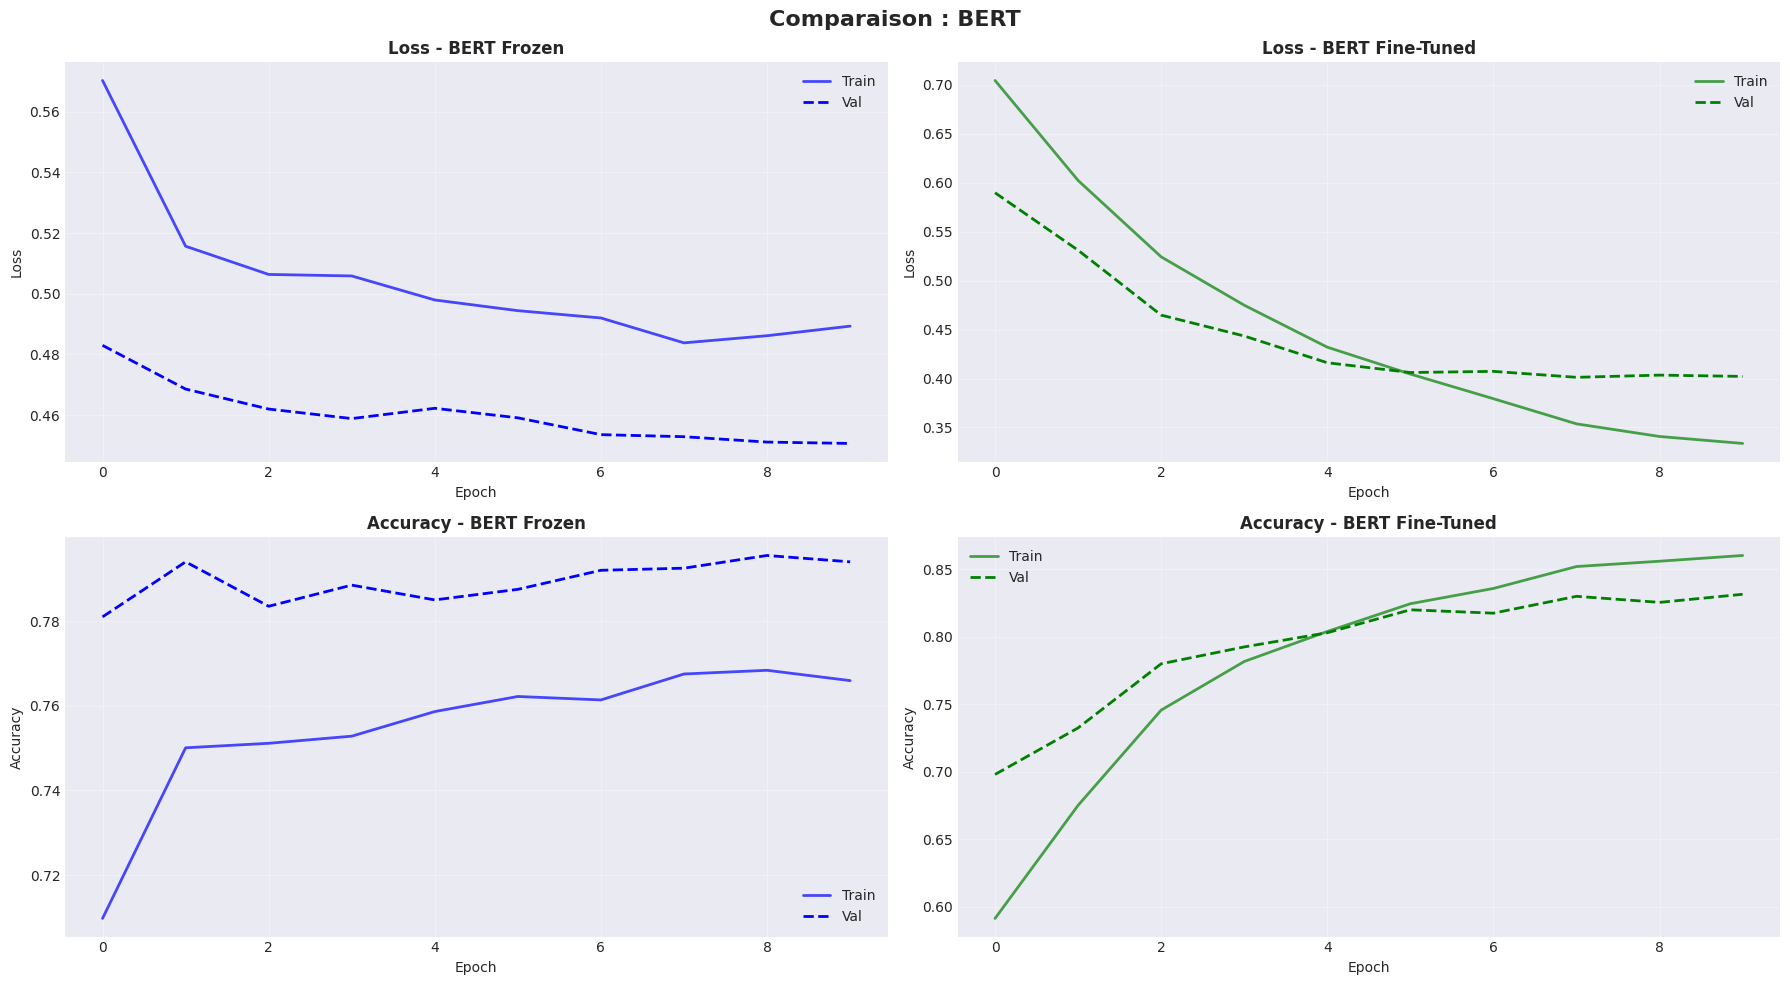

In [29]:
models_histories = [
    ('BERT Frozen', history_bert_frozen, 'blue'),
    ('BERT Fine-Tuned', history_bert_finetuned, 'green')
]

# Visualisation comparative
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Comparaison : BERT', fontsize=16, fontweight='bold')

# Loss
for idx, (name, history, color) in enumerate(models_histories):
    ax = axes[0, idx]
    ax : plt.Axes
    ax.plot(history.history['loss'], label='Train', linewidth=2, color=color, alpha=0.7)
    ax.plot(history.history['val_loss'], label='Val', linewidth=2, color=color, linestyle='--')
    ax.set_title(f'Loss - {name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(alpha=0.3)

# Accuracy
for idx, (name, history, color) in enumerate(models_histories):
    ax = axes[1, idx]
    ax : plt.Axes
    ax.plot(history.history['accuracy'], label='Train', linewidth=2, color=color, alpha=0.7)
    ax.plot(history.history['val_accuracy'], label='Val', linewidth=2, color=color, linestyle='--')
    ax.set_title(f'Accuracy - {name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Évaluation Finale

In [30]:
# BERT Frozen
bert_frozen_test_loss, bert_frozen_test_acc = bert_frozen_model.evaluate(X_test_bert, y_test, verbose=0)
y_pred_bert_frozen = (bert_frozen_model.predict(X_test_bert, verbose=0) > 0.5).astype(int).flatten()

# BERT Fine-Tuned
bert_ft_test_loss, bert_ft_test_acc = bert_finetuned_model.evaluate(X_test_bert, y_test, verbose=0)
y_pred_bert_ft = (bert_finetuned_model.predict(X_test_bert, verbose=0) > 0.5).astype(int).flatten()

# Tableau comparatif
results_df = pd.DataFrame({
    'Modèle': ['BERT Frozen', 'BERT Fine-Tuned'],
    'Test Loss': [bert_frozen_test_loss, bert_ft_test_loss],
    'Test Accuracy': [bert_frozen_test_acc, bert_ft_test_acc],
})

print("\n")
print(results_df.to_string(index=False))
print("\n" + "=" * 80)

best_idx = results_df['Test Accuracy'].idxmax()
print(f"\n🏆 MEILLEUR: {results_df.loc[best_idx, 'Modèle']} - {results_df.loc[best_idx, 'Test Accuracy']*100:.2f}%")



         Modèle  Test Loss  Test Accuracy
    BERT Frozen   0.441163         0.7885
BERT Fine-Tuned   0.405969         0.8175


🏆 MEILLEUR: BERT Fine-Tuned - 81.75%


### Matrices de Confusion

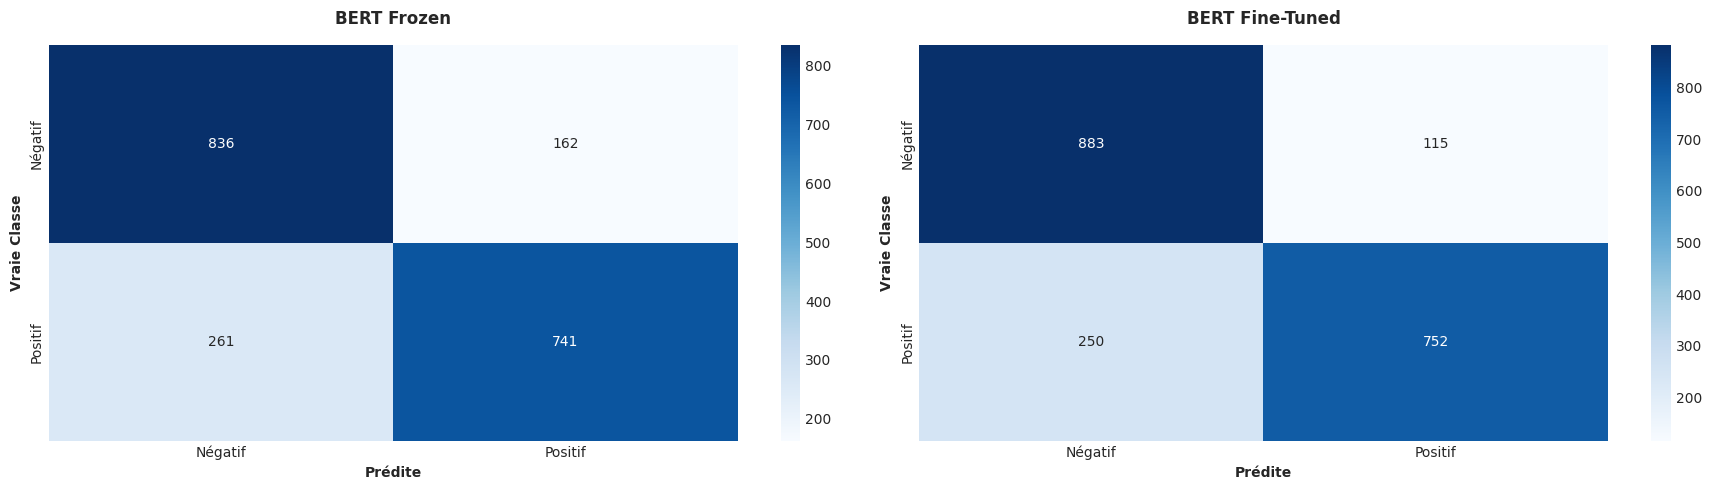

In [31]:
# Matrices de confusion
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

predictions = [
    ('BERT Frozen', y_pred_bert_frozen),
    ('BERT Fine-Tuned', y_pred_bert_ft)
]

for idx, (name, y_pred) in enumerate(predictions):
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Négatif', 'Positif'],
                yticklabels=['Négatif', 'Positif'])
    
    ax = axes[idx]
    ax : plt.Axes
    
    ax.set_title(f'{name}', fontsize=12, fontweight='bold', pad=15)
    ax.set_ylabel('Vraie Classe', fontweight='bold')
    ax.set_xlabel('Prédite', fontweight='bold')

plt.tight_layout()
plt.show()

### Classification reports

- **precision**: "Quand je prédit positif à quel point je me trompe"
    - 0.85 = Sur 100 prédictions "positif", 85 sont vraiment positives, 15 sont des erreurs

- **recall**: "Sur tous les vrais positifs, combien j'en ai trouvés ?"
    - 0.75 = Sur 100 reviews vraiment positives, j'en ai trouvé 75, j'en ai raté 25
    
- **f1-score** : "Si precision=0.80 et recall=0.70 → F1=0.75"
- **support**: ""Nombre d'échantillons de la classe"

- **Accuracy** = Bonnes prédictions / Total
- **Weighted avg** = reflète la performance globale

In [32]:
# Reports détaillés
for name, y_pred in predictions:
    print(f"\n{name}:")
    print("-" * 80)
    print(classification_report(y_test, y_pred, target_names=['Négatif', 'Positif']))


BERT Frozen:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     Négatif       0.76      0.84      0.80       998
     Positif       0.82      0.74      0.78      1002

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000


BERT Fine-Tuned:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     Négatif       0.78      0.88      0.83       998
     Positif       0.87      0.75      0.80      1002

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



## Tests sur Nouvelles Reviews

### Création de reviews de tests rapide

In [33]:
# Reviews de test
test_reviews = [
    "This game was absolutely amazing! The graphics and gameplay was superb.",
    "Terrible game. Waste of time and money. The worst game ever.",
    "It was okay, nothing special. Some good moments but forgettable.",
    "Brilliant masterpiece! One of the best games of the decade!",
    "Boring and predictable. The actors tried but the script was awful.",
    "I loved every minute! The graphics were stunning."
]

### Preprocessor sur test_reviews

In [34]:
test_preprocessed = preprocessor(test_reviews)

### Prediction à partir du modèle fine tuned

In [35]:
predictions_prob = bert_finetuned_model.predict(test_preprocessed, verbose=0).flatten()

2025-12-09 16:00:33.380665: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 432 bytes spill stores, 336 bytes spill loads

2025-12-09 16:00:33.544987: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 232 bytes spill stores, 232 bytes spill loads

2025-12-09 16:00:33.555645: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_19', 388 bytes spill stores, 388 bytes spill loads

2025-12-09 16:00:33.628744: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 424 bytes spill stores, 352 bytes spill loads



### Résultats

In [36]:
for i, (review, prob) in enumerate(zip(test_reviews, predictions_prob), 1):
    
    sentiment = "POSITIF" if prob > 0.5 else "NÉGATIF" #sentiment prediction
    confidence = prob if prob > 0.5 else 1 - prob #confidence score
    
    print(f"\n{i}. \"{review}\"")
    print(f"   {sentiment} (Confiance: {confidence*100:.1f}%)")
    print("-" * 90)


1. "This game was absolutely amazing! The graphics and gameplay was superb."
   POSITIF (Confiance: 94.8%)
------------------------------------------------------------------------------------------

2. "Terrible game. Waste of time and money. The worst game ever."
   NÉGATIF (Confiance: 99.1%)
------------------------------------------------------------------------------------------

3. "It was okay, nothing special. Some good moments but forgettable."
   POSITIF (Confiance: 60.0%)
------------------------------------------------------------------------------------------

4. "Brilliant masterpiece! One of the best games of the decade!"
   POSITIF (Confiance: 99.7%)
------------------------------------------------------------------------------------------

5. "Boring and predictable. The actors tried but the script was awful."
   NÉGATIF (Confiance: 99.2%)
------------------------------------------------------------------------------------------

6. "I loved every minute! The graphics 

## Exporter un premier modèle

In [37]:
# Sauvegarder le modèle finetuned
bert_finetuned_model.save("../outputs/models/poc/bert_base_model_ipynb.keras")

# On ne sauvegarde pas le preprocessor car on ne peut pas le sauvegarder avec keras
# Il faut le recréer à partir de la config
# preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
#     "bert_small_en_uncased",
#     sequence_length=128
# )

## Conclusion

Dans ce notebook, nous avons exploré :

1. **Transfer Learning** avec BERT
2. **KerasNLP** : Solution officielle Keras 3
3. **Feature Extraction** vs **Fine-Tuning**

### Première baseline finetuning

Sur un premier petit subset et un preset small on obtient une accuracy de **~0.82** en fine tuning.
Pour la suite du projet en va ce concentrer sur la technique du finetuning.

### Prochaine étape : entrainement de plusieurs modèles pour expérimenter et trouver les meilleures hyperparamétres.